In [1]:
import os
os.chdir(r'7 - Putting it together')
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)
from midi_encoding import *
from data_loading import *
from model import *

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
!nvidia-smi

Sun Sep 15 11:35:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.02              Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:01:00.0  On |                  Off |
| 30%   31C    P0             56W /  450W |    2618MiB /  24564MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
score_path = Path(f'../data/numpy/vg_large/all')
midi_path = Path('../data/midi/vg_large')
midi_file_names = [f for f in os.listdir(midi_path) if os.path.isfile(os.path.join(midi_path, f))]

# Ensure files are shuffled directly after assignment.
# If they are shuffled in a different cell, and that cell is run multiple times, the order will change as we are shuffling the already-shuffled list.
random.seed(42)
random.shuffle(midi_file_names)

len(midi_file_names)

3839

In [4]:
n1 = int(0.8 * len(midi_file_names))
n2 = int(0.9 * len(midi_file_names))
train_filenames = midi_file_names[:n1]
valid_filenames = midi_file_names[n1:n2]
test_filenames = midi_file_names[n2:]

print(f'Train file names: {len(train_filenames)}, Valid file names: {len(valid_filenames)}, Test file names: {len(test_filenames)}')

Train file names: 3071, Valid file names: 384, Test file names: 384


In [5]:
max_vocab_size = 1000
vocab_name = f'vg_large-actions_{max_vocab_size}'
vocab_state_dict_path = Path(f'../data/vocab/{vocab_name}.pkl')

MidiDataset says "Look for the given filenames at the given score path. Load if they exist, if not create them'.

We can use this to encode with the trained vocab if we pass it in as a param.

In [6]:
sample_length = 256
max_file_length = 32

if not vocab_state_dict_path.exists():
    
    # Load (and / or create) dataset of unmerged samples
    untrained_vocab = MusicVocab()
    untrained_vocab_size = untrained_vocab.initial_size
    print(f'Untrained vocab size: {untrained_vocab_size}')
    vocab_training_dataset = MidiDataset(midi_file_names, midi_path, score_path, sample_length, max_file_length)
    print(f"Loading unmerged samples...")
    vocab_training_dataset.load_samples(untrained_vocab, "cpu")

    # Train the vocab on the unmerged dataset, so it can learn the merges
    print(f"Training vocab, adding {max_vocab_size - untrained_vocab_size} tokens...")
    trained_vocab = MusicVocab()
    trained_vocab.train(vocab_training_dataset, max_vocab_size=max_vocab_size)
    print(f'Trained vocab size: {trained_vocab.size}')
    print(f"Saving vocab with actions:\n{trained_vocab.actions}")
    trained_vocab.save(vocab_state_dict_path)
else:
    print(f"Loading vocab...")
    trained_vocab = MusicVocab()
    trained_vocab.load(vocab_state_dict_path)
    print(f"Loaded vocab with actions:\n{trained_vocab.actions}")
    print(f'Trained vocab size: {trained_vocab.size}')

Loading vocab...
Loaded vocab with actions:
[(47, 136, 3, 136), (52, 136, 3, 136), (54, 136, 3, 136), (49, 136, 3, 136), (59, 136, 3, 136), (45, 136, 3, 136), (56, 136, 3, 136), (61, 136, 3, 136), (44, 136, 3, 136), (40, 136, 3, 136), (64, 136, 3, 136), (66, 136, 3, 136), (57, 136, 3, 136), (50, 136, 3, 136), (51, 136, 3, 136), (42, 136, 3, 136), (68, 136, 3, 136), (47, 134, 3, 134), (71, 136, 3, 136), (46, 136, 3, 136), (63, 136, 3, 136), (48, 136, 3, 136), (55, 136, 3, 136), (76, 136, 3, 136), (73, 136, 3, 136), (54, 134, 3, 134), (49, 134, 3, 134), (52, 134, 3, 134), (78, 134, 3, 134), (69, 136, 3, 136), (59, 134, 3, 134), (44, 134, 3, 134), (71, 134, 3, 134), (58, 136, 3, 136), (53, 136, 3, 136), (78, 136, 3, 136), (73, 134, 3, 134), (62, 136, 3, 136), (76, 134, 3, 134), (80, 134, 3, 134), (43, 136, 3, 136), (45, 134, 3, 134), (47, 134, 3, 136), (75, 136, 3, 136), (83, 136, 3, 136), (60, 136, 3, 136), (66, 134, 3, 134), (64, 134, 3, 134), (80, 136, 3, 136), (75, 134, 3, 134), (83, 

In [7]:
merged_score_path = Path(f'../data/numpy/{vocab_name}')
os.makedirs(merged_score_path, exist_ok=True)

# Use the trained vocab to load GPU datasets, which will create merged samples if we pass a new path
train_dataset = MidiDataset(train_filenames, midi_path, merged_score_path, sample_length, max_file_length)
valid_dataset = MidiDataset(valid_filenames, midi_path, merged_score_path, sample_length, max_file_length)
test_dataset = MidiDataset(test_filenames, midi_path, merged_score_path, sample_length, max_file_length)

print(f'Loading train samples')
train_dataset.load_samples(trained_vocab, device)

print(f'Loading valid samples')
valid_dataset.load_samples(trained_vocab, device)

print(f'Loading test samples')
test_dataset.load_samples(trained_vocab, device)

Loading train samples


/opt/conda/lib/python3.10/site-packages/torch/nested/__init__.py:166: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905979055/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


Loading valid samples
Loading test samples


In [8]:
print(f'Train files: {len(train_dataset.file_lengths)}, Valid files: {len(valid_dataset.file_lengths)}, Test files: {len(test_dataset.file_lengths)}')

Train files: 2229, Valid files: 281, Test files: 283


In [9]:
# Batch size can be changed for a second phase of training quite quickly, it only requires re-computing the indices, not re-loading the data.
batch_size = 32
train_sampler = ContiguousBatchSampler(train_dataset)
valid_sampler = ContiguousBatchSampler(valid_dataset)
test_sampler = ContiguousBatchSampler(test_dataset)

print(f'Precomputing indices')
train_sampler.precompute_indices(batch_size)
valid_sampler.precompute_indices(batch_size)
test_sampler.precompute_indices(batch_size)

train_data_loader = DataLoader(train_dataset, batch_sampler=train_sampler)
valid_data_loader = DataLoader(valid_dataset, batch_sampler=valid_sampler)
test_data_loader = DataLoader(test_dataset, batch_sampler=test_sampler)

Precomputing indices


In [10]:
model_name = f'midi_transformer_knn-xl_{vocab_name}-v2 '
model_load_path = Path(f'../data/checkpoints/{model_name}.dat')
model_save_path = Path(f'../data/checkpoints/{model_name}.dat')
log_dir = Path(f'../tensorboard/{model_name}')
tensorboard_writer = SummaryWriter(log_dir)

In [11]:
model = DecoderTransformer_KNN_XL(vocab=trained_vocab, sample_length=sample_length, max_file_length=max_file_length, device=device, use_knn=True)

print(sum(p.numel() for p in model.parameters()))

11815534


In [12]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_embedding.weight 	 torch.Size([1000, 384])
rel_pos.relative_attention_embedding.weight 	 torch.Size([32, 6])
rel_pos_knn.relative_attention_embedding.weight 	 torch.Size([32, 6])
beat_embedding.weight 	 torch.Size([32, 384])
bar_embedding.weight 	 torch.Size([1024, 384])
blocks.0.attention.key.weight 	 torch.Size([384, 384])
blocks.0.attention.query.weight 	 torch.Size([384, 384])
blocks.0.attention.value.weight 	 torch.Size([384, 384])
blocks.0.attention.project.weight 	 torch.Size([384, 384])
blocks.0.attention.project.bias 	 torch.Size([384])
blocks.0.ff.net.0.weight 	 torch.Size([1536, 384])
blocks.0.ff.net.0.bias 	 torch.Size([1536])
blocks.0.ff.net.3.weight 	 torch.Size([384, 1536])
blocks.0.ff.net.3.bias 	 torch.Size([384])
blocks.0.layer_norm1.weight 	 torch.Size([384])
blocks.0.layer_norm1.bias 	 torch.Size([384])
blocks.0.layer_norm2.weight 	 torch.Size([384])
blocks.0.layer_norm2.bias 	 torch.Size([384])
blocks.1.attention.key.weight 	 torch.Size([3

In [13]:
learning_rate = 3e-4
weight_decay = 1e-3
eval_iters = 100

model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

@torch.no_grad()
def estimate_loss(data_loader):
    model.eval()
        
    xl_memories = None
    losses = torch.zeros(eval_iters)
    
    # Not working
    # Start at a random point in the data, making sure we have enough data to evaluate
    # offset = random.randint(0, len(data_loader.dataset) - (eval_iters + 1))
    # data_iter = itertools.islice(iter(data_loader), offset, None)

    data_iter = iter(data_loader)

    for k in range(eval_iters):
        file_idxs, batch = next(data_iter)
        X, Y = batch[:, :-1], batch[:, 1:, 0] # drop absolute position from Y
        _, loss, xl_memories = model(file_idxs, X, xl_memories, Y)
        losses[k] = loss.item()

    model.train()
    
    return losses.mean()

In [14]:
average_log_losses = {  
    "train" : [],
    "val" : []
}

epochs = 0

def save_checkpoint(iterations):
    train_loss = estimate_loss(train_data_loader)
    val_loss = estimate_loss(valid_data_loader)
    tensorboard_writer.add_scalar('Loss/train', train_loss, iterations)
    tensorboard_writer.add_scalar('Loss/val', val_loss, iterations)
    train_log_loss = train_loss.log10().item()
    val_log_loss = val_loss.log10().item()
    average_log_losses['train'].append(train_log_loss)
    average_log_losses['val'].append(val_log_loss)
    print(f'Epoch {epochs} / Iteration {iterations}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': iterations,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'vocab_state_dict': trained_vocab.state_dict(),
        'losses': average_log_losses,
        'epochs': epochs
    }, model_save_path)

In [15]:
eval_interval = 200
total_iterations = 100000
start_iter = 0

if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    average_log_losses = checkpoint['losses']
    iterations = checkpoint['iter']
    epochs = checkpoint['epochs']
    start_iter = iterations + 1
    print(f"Loaded model from iteration {iterations}")

In [16]:
model.train()

remaining_iters = total_iterations - start_iter
if remaining_iters != -1:

    print(f"Training from epoch {epochs} for {remaining_iters} iterations")
    
    xl_memories = None
    initial_file_idxs = None
    train_data = iter(train_data_loader)
    offset_iter = start_iter

    for iteration in range(remaining_iters):
        offset_iter = iteration + start_iter

        if offset_iter % eval_interval == 0:
            # Because we don't explicitly clear xl and knn mem here, there is always a risk that the eval loop leaves the file idx
            # the same as the train loop, but with memories of the 'future' which aren't cleared. It could also break the epoch counter.
            # The risk would be much smaller with a bigger data set, but with vg_large we loop through the data quite quickly.
            save_checkpoint(offset_iter)

        # Configure minibatch
        file_idxs, batch = next(train_data)

        if initial_file_idxs is None:
            initial_file_idxs = file_idxs

        if torch.equal(initial_file_idxs, file_idxs):
            epochs += 1
        
        X, Y = batch[:, :-1], batch[:, 1:, 0]

        # Forward pass
        logits, loss, xl_memories = model(file_idxs, X, xl_memories, Y)

        # Backward pass
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    save_checkpoint(offset_iter + 1)

Training from epoch 0 for 100000 iterations


/opt/conda/lib/python3.10/site-packages/faiss/contrib/torch_utils.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  x.storage().data_ptr() + x.storage_offset() * 4)


Epoch 0 / Iteration 0: Train Loss: 7.0612, Val Loss: 7.0605
Epoch 1 / Iteration 200: Train Loss: 2.6867, Val Loss: 2.6791
Epoch 1 / Iteration 400: Train Loss: 2.6366, Val Loss: 2.6183
Epoch 2 / Iteration 600: Train Loss: 2.5961, Val Loss: 2.5815
Epoch 2 / Iteration 800: Train Loss: 2.5709, Val Loss: 2.5712
Epoch 2 / Iteration 1000: Train Loss: 2.5741, Val Loss: 2.5613
Epoch 3 / Iteration 1200: Train Loss: 2.5516, Val Loss: 2.5484
Epoch 3 / Iteration 1400: Train Loss: 2.5365, Val Loss: 2.5422
Epoch 3 / Iteration 1600: Train Loss: 2.5395, Val Loss: 2.5308
Epoch 4 / Iteration 1800: Train Loss: 2.5229, Val Loss: 2.5293
Epoch 4 / Iteration 2000: Train Loss: 2.5179, Val Loss: 2.5209
Epoch 4 / Iteration 2200: Train Loss: 2.5160, Val Loss: 2.5087
Epoch 5 / Iteration 2400: Train Loss: 2.4905, Val Loss: 2.4999
Epoch 5 / Iteration 2600: Train Loss: 2.4855, Val Loss: 2.4845
Epoch 5 / Iteration 2800: Train Loss: 2.4954, Val Loss: 2.4849
Epoch 6 / Iteration 3000: Train Loss: 2.4427, Val Loss: 2.4530

In [17]:
print('Final training loss:', 10 ** average_log_losses['train'][-1])

Final training loss: 1.0707205532620376


In [18]:
print('Final validation loss:', 10 ** average_log_losses['val'][-1])

Final validation loss: 1.1350854624427023


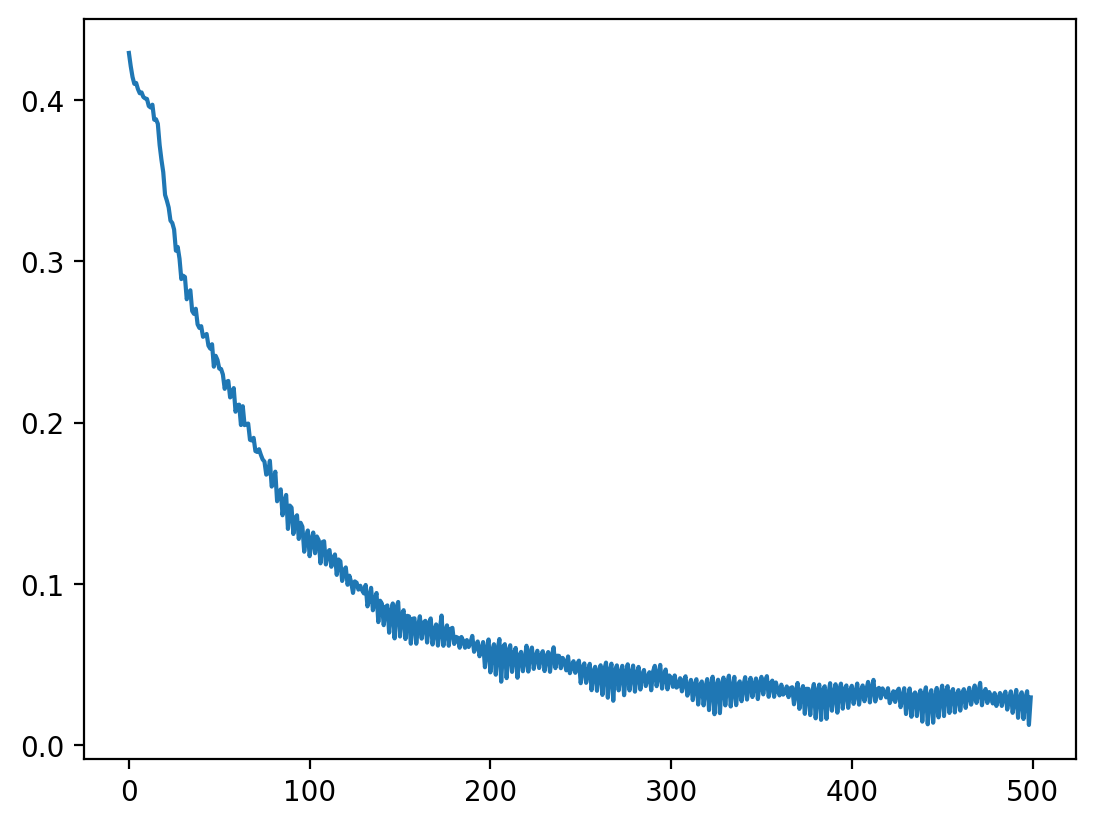

In [19]:
plt.plot(average_log_losses['train'][1:])

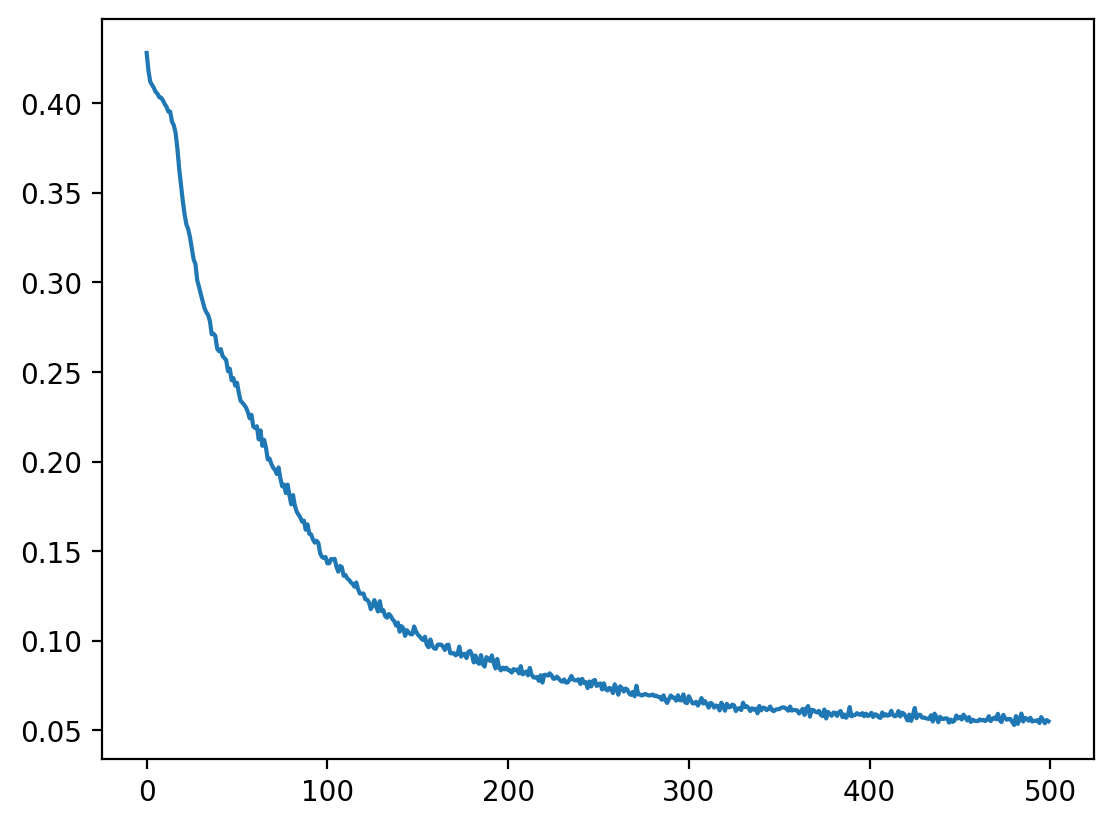

In [20]:
plt.plot(average_log_losses['val'][1:])

In [21]:
init_idx = torch.zeros((1,1,2), dtype=torch.long, device=device)
generated_tokens = model.generate(init_idx, max_new_tokens=512).cpu()

In [22]:
generated_tokens.shape

torch.Size([1, 513, 2])

In [23]:
score = generated_tokens[0, :, 0]
trained_vocab.to_tokens(score)

KeyError: tensor(0)

In [ ]:
generated_stream = idx_to_stream_enc(np.array(score), trained_vocab)
generated_stream.plot()

In [ ]:
generated_stream.show('midi')

In [ ]:
random_test_midi_file = random.choice(test_filenames)
random_test_path = Path(midi_path, random_test_midi_file)
random_test_idx_score = midifile_to_idx_score(random_test_path, trained_vocab)
random_test_intro = random_test_idx_score[:sample_length]
random_test_intro_stream = idx_to_stream_enc(np.array(random_test_intro[:, 0]), trained_vocab)
random_test_intro_stream.plot()

In [ ]:
random_test_intro_stream.show('midi')

In [ ]:
random_test_init = torch.tensor(random_test_intro, device=device).unsqueeze(0)
random_test_continued = model.generate(random_test_init, max_new_tokens=512).cpu()[0, :, 0]
random_test_continued_stream = idx_to_stream_enc(np.array(random_test_continued), trained_vocab)
random_test_continued_stream.plot()

In [ ]:
random_test_continued_stream.show('midi')

> UMAP (Universal Manifold Approximation and Projection) can take high dim embeddings and try to plot them in 2D, maintaining info 

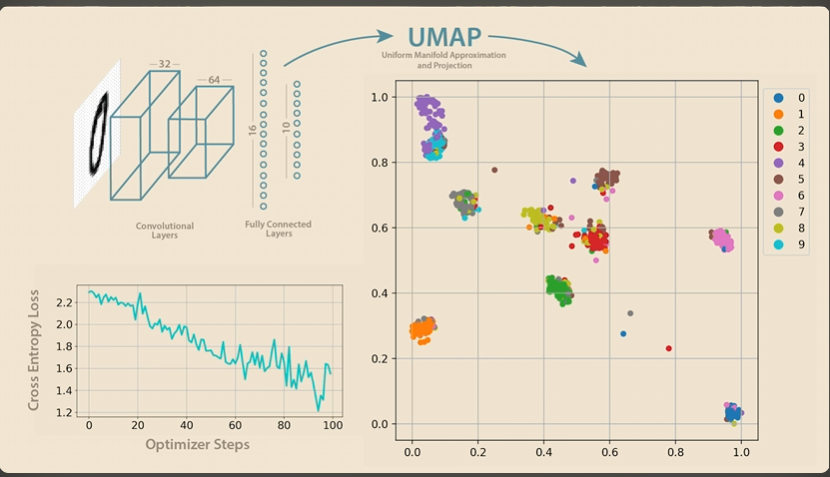

In [ ]:
def group_by_timestep(data, include_position=False):
    grouped = {}
    for idx, position in data:
        if position not in grouped:
            grouped[position] = []
        grouped[position].append(idx)
    
    if include_position:
        result = [(tuple(values), position) for position, values in grouped.items()]
    else:
        result = [tuple(values) for values in grouped.values()]
    return result

data = [[1, 0], [2, 0], [3, 0], [4, 1], [5, 1], [6, 2], [7, 2], [8, 2], [9, 2]]

grouped_data = group_by_timestep(data, include_position=False)
print(grouped_data)

In [ ]:
grouped_data = group_by_timestep(data, include_position=True)
print(grouped_data)

In [ ]:
actions = {}
grouped_idxs = [(1, 2, 3), (4, 5), (6, 7, 8, 9), (1, 2, 3), (1, 2, 3), (6, 7, 8, 9), (4, 5), (4, 5), (4, 5)]
for action in grouped_idxs:
    actions[action] = actions.get(action, 0) + 1
actions

In [ ]:
sorted_actions = {k: v for k, v in sorted(actions.items(), key=lambda item: item[1], reverse=True)}
sorted_actions

In [ ]:
top_actions = list(sorted_actions.keys())[:2]
top_actions

In [ ]:
initial_size = 10

def try_replace(action, position):
    if action in top_actions:
        return [[initial_size + top_actions.index(action)], position]
    else:
        return [list(action), position]
        
replaced_score = [try_replace(action, position) for action, position in grouped_data]
replaced_score

In [ ]:
note_idx_score = []
pos_score = []
for (action, position) in replaced_score:
    for index in action:
        note_idx_score.append(index)
        pos_score.append(position)
note_idx_score

In [ ]:
pos_score

In [ ]:
for idx, action in enumerate(top_actions):
   print(' '.join([str(a) for a in action]))